# YouTube Analysis 

### By Sowmi

# Step 1: Setting Up Your Jupyter Notebook

## 1. Import Necessary Libraries

In [30]:
import os
import pandas as pd
from googleapiclient.discovery import build
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Matplotlib for inline display
%matplotlib inline

## 2. Initialize the YouTube Data API Client

In [18]:
api_key = os.getenv('YOUTUBE_API_KEY')  
youtube = build('youtube', 'v3', developerKey=api_key)

# Step 2: Define Functions to Fetch Data

## 1. Fetch Channel Statistics

In [19]:
def get_channel_stats(youtube, channel_id):
    request = youtube.channels().list(
        part='snippet,contentDetails,statistics',
        id=channel_id
    )
    response = request.execute()

    if 'items' in response and response['items']:
        data = response['items'][0]
        stats = {
            'channelName': data['snippet']['title'],
            'subscribers': int(data['statistics']['subscriberCount']),
            'views': int(data['statistics']['viewCount']),
            'totalVideos': int(data['statistics']['videoCount']),
            'playlistId': data['contentDetails']['relatedPlaylists']['uploads']
        }
        return stats
    else:
        return None


## 2. Fetch Video IDs from Playlist

In [20]:
def get_video_ids(youtube, playlist_id):
    video_ids = []
    next_page_token = None
    
    while True:
        request = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()
        
        video_ids.extend([item['contentDetails']['videoId'] for item in response['items']])
        
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
            
    return video_ids


## 3. Fetch Detailed Statistics for Videos

In [21]:
def get_video_details(youtube, video_ids):
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='snippet,contentDetails,statistics',
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            video_info = {
                'video_id': video['id'],
                'title': video['snippet']['title'],
                'views': int(video['statistics'].get('viewCount', 0)),
                'likes': int(video['statistics'].get('likeCount', 0)),
                'comments': int(video['statistics'].get('commentCount', 0)),
                'published_at': video['snippet']['publishedAt']
            }
            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)


# Step 3: Fetch and Analyze Data

In [31]:
channel_stats = get_channel_stats(youtube, 'UCEMArgthHuEtX-04qL_8puQ')
if channel_stats:
    channel_stats_df = pd.DataFrame([channel_stats])
    display(channel_stats_df)
else:
    print("Failed to retrieve channel statistics.")

# Fetch and display video details
video_ids = get_video_ids(youtube, channel_stats['playlistId'])
video_details = get_video_details(youtube, video_ids)
display(video_details.head(10))  # Show details of the first 10 videos

,channelName,subscribers,views,totalVideos,playlistId
0,Goodful,1610000,243303445,962,UUEMArgthHuEtX-04qL_8puQ


,video_id,title,views,likes,comments,published_at
0,72Dr5CRF0RU,Mulled Wine,10160,458,4,2023-12-10T19:22:00Z
1,Vs5DhA3D1JQ,Cozy Chai,9991,525,15,2023-12-09T19:19:00Z
2,D-wX0YLmguo,Roasted Tomato Rosemary Soup,7451,425,5,2023-12-08T18:57:00Z
3,rc5Y1W7ODtc,One pan vegetarian Gnocchi,10369,353,3,2023-12-04T18:18:57Z
4,VMf7XWNTxQI,White Bean Kale Soup,5589,269,7,2023-11-30T17:31:00Z
5,qg1-ZDa0gYM,One pan meal with Krista,7915,308,2,2023-11-27T19:47:46Z
6,s-ioEcetApc,Cauliflower Stuffing,6663,251,6,2023-11-13T18:20:00Z
7,jUmnKJZYk-Y,Creamy Mushroom Soup,7327,453,5,2023-11-09T19:52:53Z
8,Cey5r2Kow48,Unstuffed Pepper Skillet,7616,451,12,2023-11-07T18:04:58Z
9,UDRpxZ1vdgI,Mushroom Wild Rice Soup,7736,468,11,2023-11-02T18:08:00Z


# Step 4: Data Visualization 

Text(0.5, 1.0, 'Top 10 Videos by View Count')

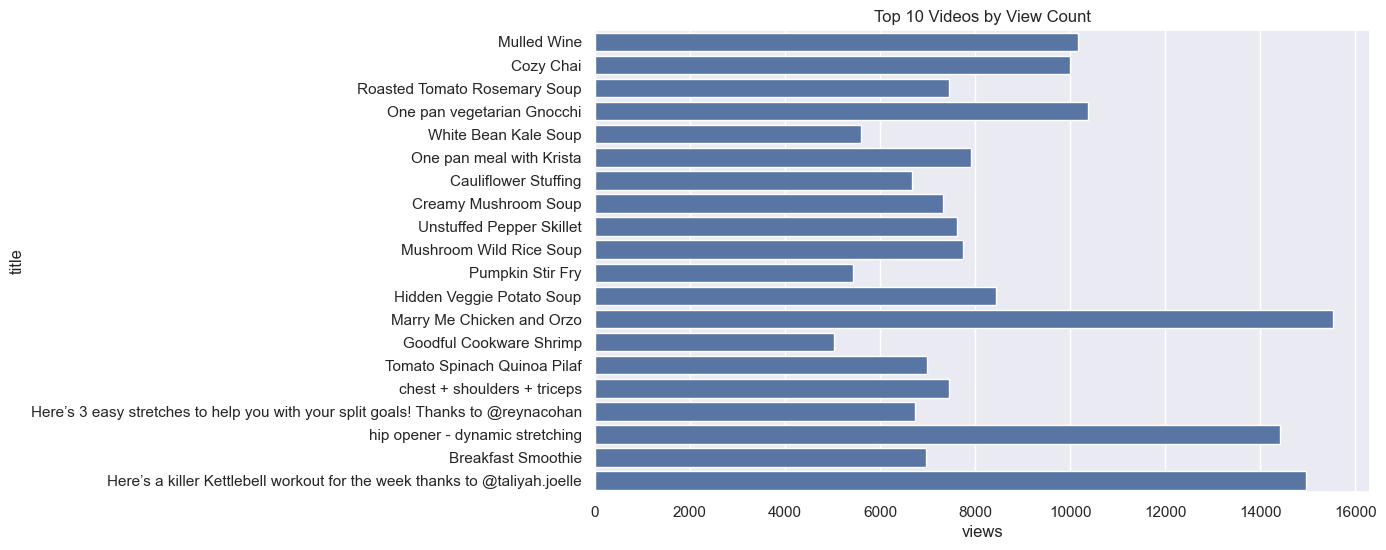

In [29]:
# Plotting views of each video
plt.figure(figsize=(10, 6))
sns.barplot(x='views', y='title', data=video_details.head(20))  # Display the top 10 videos
plt.title('Top 10 Videos by View Count')